In [4]:
################################################################
# Frozen Lake v1 : Q value iteration examples
################################################################

import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

# Parameters 
GAMMA = 0.9
ENV_NAME = "FrozenLake-v1"

# parent class
class GameAgent():
    def __init__(self, env_name):
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.STATE_DIM = self.env.observation_space.n
        self.ACTION_DIM = self.env.action_space.n
        self.epsilon = 0.5
        self.GAMMA = GAMMA
        self.lr = 0.1
        self.num_episodes = 100
    
    def initialize_game(self):
        state, _ = self.env.reset() 
        return state
    
    def select_action(self, current_state=None):
        action = self.env.action_space.sample()
        return action
        
    def step_game(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        return next_state, reward, terminated
        
    def run_episode(self, training=True):
        current_state = self.initialize_game()
        terminated = False
        episode_reward = 0.0
    
        while not terminated:
            # choose action
            action = self.select_action(current_state)
            
            # take action
            next_state, reward, terminated = self.step_game(action)

            # prepare next step
            current_state = next_state
            episode_reward += reward

        return episode_reward
    
    def run_epoch(self, training=True):
        rewards = np.zeros(self.num_episodes)
        for i in range(self.num_episodes):
            rewards[i] = self.run_episode(training)
        return rewards.mean()
    



In [5]:
# child class
class ModelFreeAgent(GameAgent):
    def __init__(self, env_name):
        super(ModelFreeAgent, self).__init__(env_name)
        self.q_table = np.zeros([self.STATE_DIM, self.ACTION_DIM])
        self.values = np.zeros(self.STATE_DIM)
        self.epsilon = 0.5
        self.GAMMA = GAMMA
        self.lr = 0.2
        self.num_episodes = 200
        
    def epsilon_greedy(self, state):
        if np.random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            _, action = np.unravel_index(np.argmax(self.q_table[state, :]), self.q_table.shape)
        return action
    
    def select_action(self, state):
        return self.epsilon_greedy(state)

    def update_q_table(self, current_state, action, next_state, reward, terminated):
        q_max = self.q_table[next_state, :].max() 
        if not terminated:
            self.q_table[current_state, action] += self.lr * (reward + self.GAMMA * q_max - self.q_table[current_state, action]) 
        else:
            self.q_table[current_state, action] += self.lr * (reward - self.q_table[current_state, action]) 
        
    def run_episode(self, training=True):
        current_state = self.initialize_game()
        terminated = False
        episode_reward = 0.0
        self.epsilon = 0.5 if training else 0.01
        
        while not terminated:
            # choose action
            action = self.select_action(current_state)
            
            # take action
            next_state, reward, terminated = self.step_game(action)
            
            # update q_table
            if training:
                self.update_q_table(current_state, action, next_state, reward, terminated)

            # prepare next step
            current_state = next_state
            episode_reward += reward

        return episode_reward
    
    def get_policy(self):
        policy = np.argmax(self.q_table, axis=1)
        return policy
    
    def run_epoch(self, training=True):
        rewards = np.zeros(self.num_episodes)
        for i in range(self.num_episodes):
            rewards[i] = self.run_episode(training)
        return rewards.mean()

    
def model_free_example():
    num_epochs = 20
    agent = ModelFreeAgent(ENV_NAME)
    for i in tqdm(range(num_epochs)):
        agent.run_epoch()
    print("")
    print("optimal policy:")
    print(agent.get_policy().reshape(4,4))
    
    rewards = np.zeros(num_epochs)
    for i in tqdm(range(num_epochs)):
        rewards[i] = agent.run_epoch(training=False)
    print("")
    print(rewards.mean())

if __name__ == '__main__':
    model_free_example()


100%|██████████| 20/20 [00:02<00:00,  8.40it/s]



optimal policy:
[[0 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


0.7217499999999999


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


optimal policy: 
 [[0 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]
average reward after 100th iteration: 0.7800999999999999


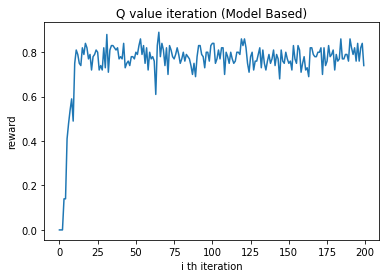

In [7]:

# child class
class ModelBasedAgent(GameAgent):
    def __init__(self, env_name):
        super(ModelBasedAgent, self).__init__(env_name)
        self.q_table = np.zeros([self.STATE_DIM, self.ACTION_DIM])
        self.transtions_model = np.zeros([self.STATE_DIM, self.ACTION_DIM, self.STATE_DIM])
        self.rewards_model = np.zeros([self.STATE_DIM, self.ACTION_DIM, self.STATE_DIM])
        self.num_episodes = 100
    
    def select_action(self, state, training=True):
        if training:
            return self.env.action_space.sample()
        else:
            _, action = np.unravel_index(np.argmax(self.q_table[state, :]), self.q_table.shape)
            return action

    def q_values_iteration(self):
        # new_q_table = np.zeros([self.STATE_DIM, self.ACTION_DIM])
        for current_state in range(self.STATE_DIM):
            for action in range(self.ACTION_DIM):
                total_transition = self.transtions_model[current_state, action, :].sum()
                if total_transition == 0.0:
                   continue
                total_bb = 0.0
                probs = self.transtions_model[current_state, action, :] / total_transition
                rewards = self.rewards_model[current_state, action, :] 
                for next_state in range(self.STATE_DIM):
                    reward = rewards[next_state]
                    transition_prob = probs[next_state] 
                    q_max = self.q_table[next_state, :].max()
                    bellman_backup = reward + self.GAMMA * q_max
                    total_bb += transition_prob * bellman_backup
                self.q_table[current_state, action] = total_bb
        
    
    def count_transition(self, current_state, action, next_state):
        self.transtions_model[current_state, action, next_state] += 1
    
    def count_reward(self, current_state, action, next_state, reward):
        self.rewards_model[current_state, action, next_state] = reward
        
    def run_episode(self, training=True):
        current_state = self.initialize_game()
        terminated = False
        episode_reward = 0.0
        
        while not terminated:
            # choose action
            action = self.select_action(current_state, training)
            
            # take action
            next_state, reward, terminated = self.step_game(action)
            
            # learn the model
            self.count_transition(current_state, action, next_state)
            self.count_reward(current_state, action, next_state, reward)
            
            # prepare next step
            current_state = next_state
            episode_reward += reward

        return episode_reward
        
    def run_epoch(self, training=True):
        rewards = np.zeros(self.num_episodes)
        for i in range(self.num_episodes):
            rewards[i] = self.run_episode(training)
        return rewards.mean()
    
    def get_policy(self):
        policy = np.argmax(self.q_table, axis=1)
        return policy
        


def model_based_example():
    agent = ModelBasedAgent(ENV_NAME)
    iter_n = 0
    num_epochs = 200
    average_rewards = np.zeros(num_epochs)
    for iter_n in tqdm(range(num_epochs)):
        # training
        agent.run_epoch(training=True)
        agent.q_values_iteration()
    
        # testing
        average_reward = agent.run_epoch(training=False)
        average_rewards[iter_n] = average_reward
    
    # print the optimal policy
    policy = agent.get_policy()
    print("optimal policy: \n", policy.reshape(4,4)) # almost optimal?
    
    # the optimal reward is about 0.78
    print("average reward after 100th iteration:", average_rewards[100:].mean())
    
    # plot average rewards
    fig, ax = plt.subplots()
    ax.plot(average_rewards) 
    ax.set_title('Q value iteration (Model Based)')
    ax.set_xlabel('i th iteration')
    ax.set_ylabel('reward')

if __name__ == '__main__':
    model_based_example()
